In [432]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import gmaps
%matplotlib inline
from env import google_key, google_key1
import gmaps.datasets
gmaps.configure(api_key=google_key1) # Fill in with your API key

In [2]:
colnames=['date', 'time','destination','student_id', 'cohort',
          'ip' ]
df = pd.read_csv('curriculum-access.txt', engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 1, 2, 3, 4, 5, 6])

In [4]:
df['datetime'] = df['date'] + ' ' + df['time']
df['datetime'] = pd.to_datetime(df.datetime)
df = df.drop(columns = ['date', 'time'])
df = df.set_index('datetime')
df.head()

,destination,student_id,cohort,ip
datetime,,,,
2018-01-26 09:55:03,/,1,8.0,98.106.20.62
2018-01-26 09:56:02,java-ii,1,8.0,98.106.20.62
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,98.106.20.62
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62


In [14]:
curie = df[df.cohort == 55]
bayes = df[df.cohort == 34]

In [6]:
ada_list = pd.Series([349, 350, 351, 352, 353, 354, 355, 357, 358, 359, 360, 361,
       362, 363, 364, 365, 366, 367, 368, 369,  372])
ada = df[df['student_id'].isin(ada_list)]

In [9]:
ada.cohort = 100

In [76]:
ds = pd.concat([ada, bayes, curie])

In [77]:
ds = ds.dropna()

In [78]:
ds.head(2)

,destination,student_id,cohort,ip
datetime,,,,
2019-02-04 16:22:20,/,349,100.0,98.106.20.59
2019-02-04 16:22:36,/,350,100.0,98.106.20.59


In [79]:
ds['hour'] = ds.index.hour

In [80]:
ds.head(2)

,destination,student_id,cohort,ip,hour
datetime,,,,,
2019-02-04 16:22:20,/,349,100.0,98.106.20.59,16
2019-02-04 16:22:36,/,350,100.0,98.106.20.59,16


In [81]:
hours = ds.groupby(['hour'])['student_id'].agg(['nunique'])

In [119]:
ds.head(2)

,destination,student_id,cohort,ip,hour
datetime,,,,,
2019-02-04 16:22:20,/,349,100.0,98.106.20.59,16
2019-02-04 16:22:36,/,350,100.0,98.106.20.59,16


In [120]:
ds.columns

Index(['destination', 'student_id', 'cohort', 'ip', 'hour'], dtype='object')

In [84]:
#ds = ds.set_index(['destination', 'student_id', 'cohort', 'ip', 'hour'], append=True)

In [163]:
ds1 = ds.groupby('student_id').hour.agg(['count', 'nunique'])

In [164]:
ds1

,count,nunique
student_id,,
349,1648,24
350,87,13
351,875,19
352,773,16
353,1393,21
...,...,...
590,1020,18
591,668,14
616,388,19


In [165]:
scaler = MinMaxScaler().fit(ds1)
ds1_scaled_array = scaler.transform(ds1)
ds1_scaled_array[0:10]

array([[0.56817397, 1.        ],
       [0.0293407 , 0.52173913],
       [0.30134622, 0.7826087 ],
       [0.26613738, 0.65217391],
       [0.48015188, 0.86956522],
       [1.        , 1.        ],
       [0.49499482, 0.65217391],
       [0.20814636, 0.56521739],
       [0.78287884, 0.60869565],
       [0.17846048, 0.69565217]])

In [166]:
dbsc = DBSCAN(eps = .20, min_samples = 10).fit(ds1_scaled_array)

In [167]:
dbsc

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [168]:
ds2 = pd.DataFrame(ds1_scaled_array, columns = ['scaled_count', 'scaled_nunique'])

In [169]:
ds1 = ds1.merge(ds2, on=ds1.index)

In [170]:
ds1

,key_0,count,nunique,scaled_count,scaled_nunique
0,349,1648,24,0.568174,1.000000
1,350,87,13,0.029341,0.521739
2,351,875,19,0.301346,0.782609
3,352,773,16,0.266137,0.652174
4,353,1393,21,0.480152,0.869565
...,...,...,...,...,...
57,590,1020,18,0.351398,0.739130
58,591,668,14,0.229893,0.565217
59,616,388,19,0.133241,0.782609
60,617,405,19,0.139109,0.782609


In [171]:
#ds1 = ds1.drop(columns = 'key_0')

In [172]:
labels = dbsc.labels_
labels[0:10]

array([ 0,  0,  0,  0,  0, -1,  0,  0, -1,  0])

In [173]:
ds1['labels'] = labels
ds1.labels.value_counts()

 0    54
-1     8
Name: labels, dtype: int64

In [174]:
ds1.head(2)

,key_0,count,nunique,scaled_count,scaled_nunique,labels
0,349,1648,24,0.568174,1.000000,0
1,350,87,13,0.029341,0.521739,0


In [176]:
ds1['label'] = ds1.apply(lambda x: 'a' if x.labels == 0 else 'b', axis =1)

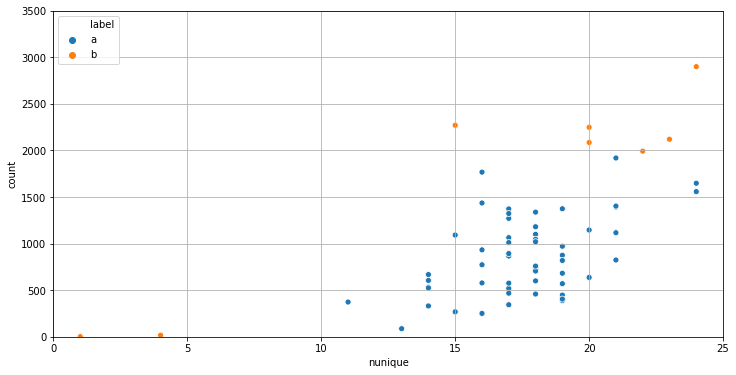

In [203]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = 'nunique', y = 'count', data = ds1, hue = 'label')
plt.grid()
plt.xlim(0,25)
plt.ylim(0,3500)
plt.legend(loc='upper left')

In [185]:
ds1[ds1['count'] == 2899]

,key_0,count,nunique,scaled_count,scaled_nunique,labels,label
5,354,2899,24,1.0,1.0,-1,b


In [189]:
ds1['count'].min()

2

In [186]:
df[df.student_id == 354]

,destination,student_id,cohort,ip
datetime,,,,
2019-02-04 16:44:49,/,354,NaN,98.106.20.59
2019-02-04 17:04:26,/,354,NaN,98.106.20.59
2019-02-05 08:46:32,/,354,NaN,98.106.20.59
2019-02-05 09:20:34,3.0-mysql-overview,354,NaN,98.106.20.59
2019-02-05 09:20:51,1._Fundamentals,354,NaN,98.106.20.59
...,...,...,...,...
2020-02-23 13:13:07,/,354,NaN,46.24.251.17
2020-02-23 13:19:51,search/search_index.json,354,NaN,46.24.251.17
2020-02-23 13:20:13,appendix/ds-environment-setup,354,NaN,46.24.251.17


In [204]:
#clustering project

In [205]:
zillow = pd.read_csv('zillow_fe.csv')


In [395]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64747 entries, 0 to 64746
Data columns (total 48 columns):
Unnamed: 0                        64747 non-null int64
bathroomcnt                       64747 non-null int64
bedroomcnt                        64747 non-null int64
finishedsquarefeet12              64747 non-null int64
garagecarcnt                      64747 non-null int64
garagetotalsqft                   64747 non-null int64
hashottuborspa                    64747 non-null int64
latitude                          64747 non-null float64
longitude                         64747 non-null float64
lotsizesquarefeet                 64747 non-null int64
poolcnt                           64747 non-null int64
poolsizesum                       64747 non-null int64
numberofstories                   64747 non-null int64
structuretaxvaluedollarcnt        64747 non-null int64
taxvaluedollarcnt                 64747 non-null int64
taxamount                         64747 non-null int64
taxdeli

In [377]:
zillow1 = zillow[['finishedsquarefeet12', 'bedroomcnt']]
zillow2 = zillow[['finishedsquarefeet12', 'taxvaluedollarcnt']]

In [378]:
scaler1 = MinMaxScaler().fit(zillow1)
zillow1_scaled_array = scaler1.transform(zillow1)
#zillow1_scaled_array[0:10]

scaler2 = MinMaxScaler().fit(zillow2)
zillow2_scaled_array = scaler2.transform(zillow2)

In [403]:
dbsc1 = DBSCAN(eps = 0.04, min_samples = 18).fit(zillow1_scaled_array)

In [397]:
dbsc2 = DBSCAN(eps = .05, min_samples = 20).fit(zillow2_scaled_array)

In [404]:
labels1 = dbsc1.labels_
labels1[0:10]
labels2 = dbsc2.labels_
labels2[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [405]:
zillow2['labels'] = labels2
zillow2.labels.value_counts()

 0    64724
-1       23
Name: labels, dtype: int64

In [406]:
zillow1['labels'] = labels1
zillow1.labels.value_counts()

 0    27606
 4    18041
 1    13526
 3     3278
 2     2271
-1       25
Name: labels, dtype: int64

In [407]:
zillow1['labels'] = zillow1.apply(lambda x: 'a' if x.labels == 0 else  ('b' if x.labels == 1 else ('c' if x.labels == 2 else ('d' if x.labels == 3 else('e' if x.labels == 4 else 'f')))) , axis =1)
zillow2['labels'] = zillow2.apply(lambda x: 'a' if x.labels == 0 else  ('b' if x.labels == 1 else ('c' if x.labels == 2 else ('d' if x.labels == 3 else('e' if x.labels == 4 else 'f')))) , axis =1)                                                           

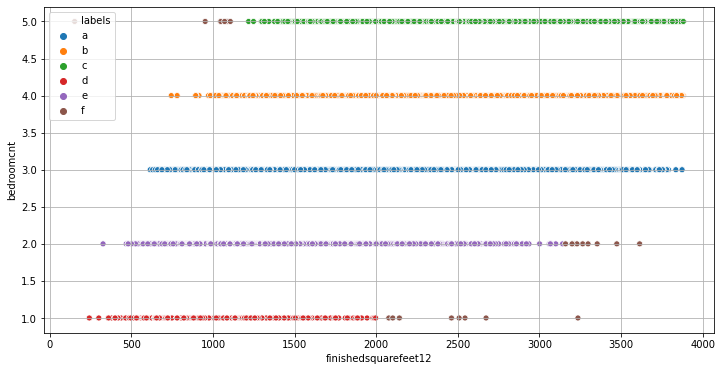

In [408]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = 'finishedsquarefeet12', y = 'bedroomcnt', data = zillow1, hue = 'labels')
plt.grid()
#plt.xlim(0,25)
#plt.ylim(0,3500)
plt.legend(loc='upper left')

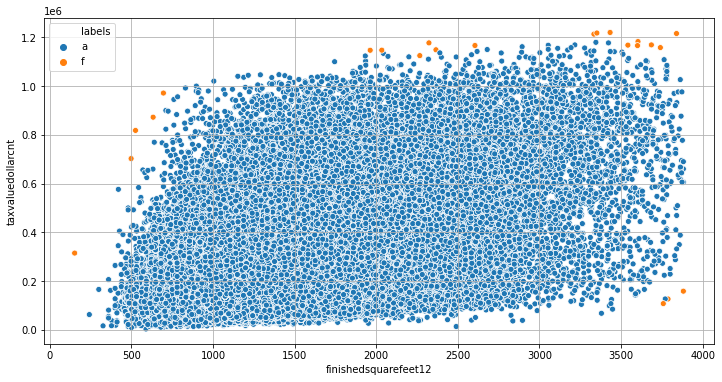

In [393]:
zillow3 = zillow2[zillow2.labels != 'f']
plt.figure(figsize = (12,6))
sns.scatterplot(x = 'finishedsquarefeet12', y = 'taxvaluedollarcnt', data = zillow2, hue = 'labels')
plt.grid()
#plt.xlim(0,25)
#plt.ylim(0,3500)
plt.legend(loc='upper left')

In [434]:
anomaly = zillow[(zillow.taxvaluedollarcnt > 200000) & (zillow.finishedsquarefeet12 < 250)]

In [435]:
anomaly

,Unnamed: 0,bathroomcnt,bedroomcnt,finishedsquarefeet12,garagecarcnt,garagetotalsqft,hashottuborspa,latitude,longitude,lotsizesquarefeet,...,age_bin,tax_bin,cluster_fancy,centroid_buildingqualitytypeid,centroid_roomcnt,centroid_is_extra,cluster_lot,centroid_lotsizesquarefeet,centroid_landtaxvaluedollarcnt,centroid_new_zip
26379,30822,2,5,152,0,0,0,33957941.0,-118239583.0,6766,...,30,0.0125,cluster_1,6.187891,0.001275,1.591607,cluster_3,0.032987,0.157055,0.10991


In [437]:
locations = anomaly[['latitude', 'longitude']]
#weights = train[train.cluster == 'cluster_2']['logerror']
fig = gmaps.figure()
fig.add_layer(gmaps.symbol_layer(locations/1000000, fill_color='red', stroke_color='red', scale=2))
fig
#plt.figure(figsize=(10, 6))
#sns.scatterplot(x = 'latitude', y = 'longitude', data = train[train.cluster =='cluster_1'], hue = 'cluster')
#gmaps.figure(center=(34.069091, -118.284055), zoom_level=12)

# fig.add_layer(gmaps.heatmap_layer(locations/1000000, weights = weights))
# gmaps.figure(center=(34.069091, -118.284055), zoom_level=12)



Figure(layout=FigureLayout(height='420px'))

In [438]:
locations = zillow[['latitude', 'longitude']]
#weights = train[train.cluster == 'cluster_2']['logerror']
fig = gmaps.figure()
fig.add_layer(gmaps.symbol_layer(locations/1000000, fill_color='red', stroke_color='red', scale=2))
fig


Figure(layout=FigureLayout(height='420px'))